In [4]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached grpcio-1.74.0-cp312-cp312-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.11.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached ml_dtypes-0.5.3-cp312-cp312-win_amd64.whl.metadata (9.2 kB)
  Using cac

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [6]:
df = pd.read_csv("data.csv")

In [7]:
df['Attrition'] = LabelEncoder().fit_transform(df['Attrition'])  # Yes=1, No=0


In [8]:
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

In [9]:
X = df.drop('Attrition', axis=1)
y = df['Attrition']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Function to evaluate model
def evaluate_model(y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0,1], [0,1], 'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

Best Params (Logistic Regression): {'C': 0.1}
Accuracy: 0.8810
Precision: 0.7727
Recall: 0.3617
F1 Score: 0.4928


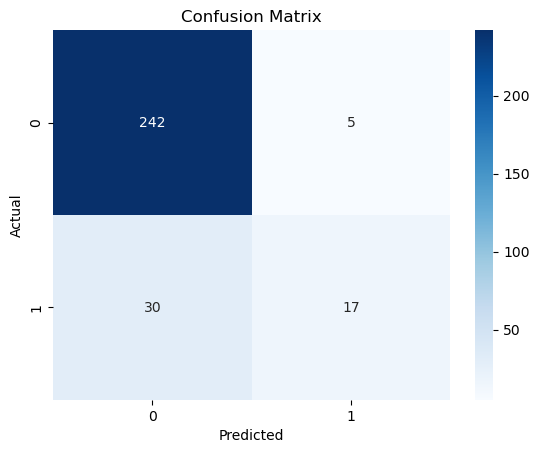

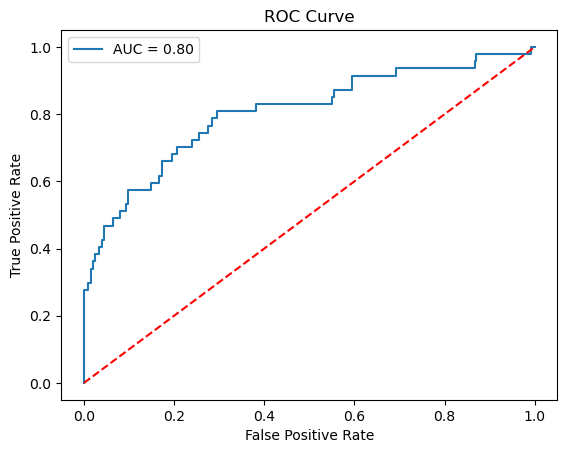

In [19]:
# 1. Logistic Regression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
params = {'C': [0.01, 0.1, 1, 10]}
grid_lr = GridSearchCV(log_reg, params, cv=5, scoring='accuracy')
grid_lr.fit(X_train_scaled, y_train)

y_pred_lr = grid_lr.predict(X_test_scaled)
y_prob_lr = grid_lr.predict_proba(X_test_scaled)[:, 1]

print("Best Params (Logistic Regression):", grid_lr.best_params_)
evaluate_model(y_test, y_pred_lr, y_prob_lr)

Best Params (Random Forest): {'max_depth': None, 'n_estimators': 100}
Accuracy: 0.8299
Precision: 0.3846
Recall: 0.1064
F1 Score: 0.1667


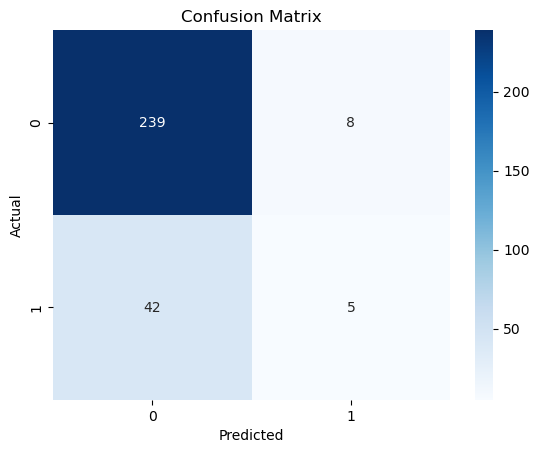

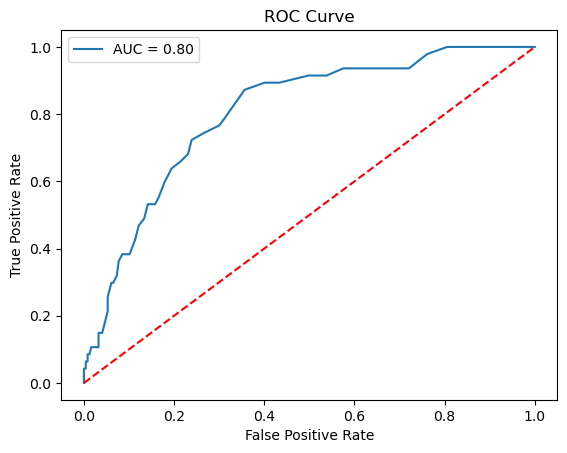

In [20]:
# 2. Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
params_rf = {'n_estimators': [100, 200], 'max_depth': [5, 10, None]}
grid_rf = GridSearchCV(rf, params_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)

y_pred_rf = grid_rf.predict(X_test)
y_prob_rf = grid_rf.predict_proba(X_test)[:, 1]

print("Best Params (Random Forest):", grid_rf.best_params_)
evaluate_model(y_test, y_pred_rf, y_prob_rf)

C:\Users\Sabarish\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.8673
Precision: 0.6429
Recall: 0.3830
F1 Score: 0.4800


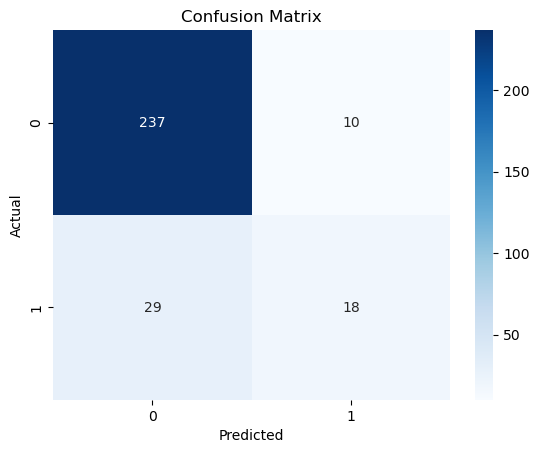

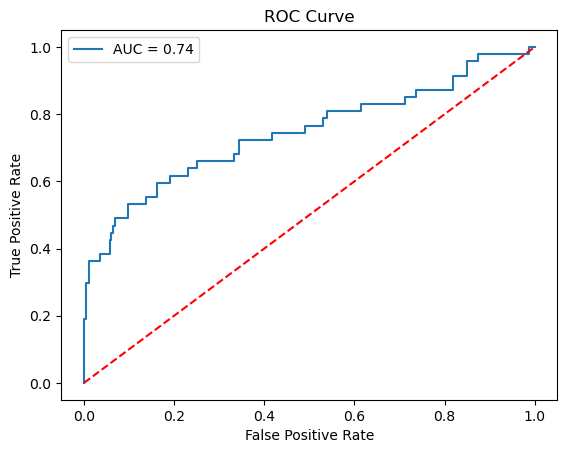

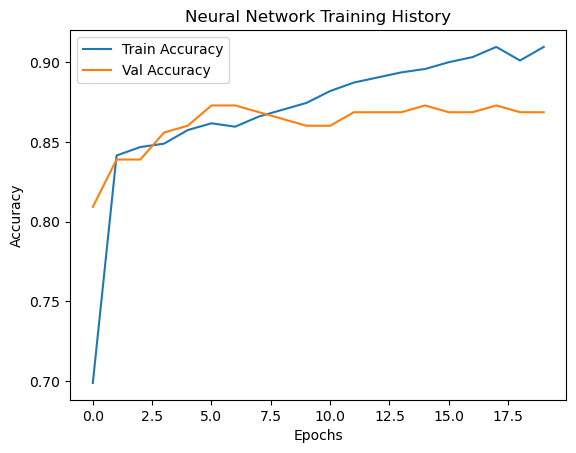

In [21]:
# 3. Basic Neural Network (Keras)
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=20, batch_size=32, verbose=0)

# Predictions
y_prob_nn = model.predict(X_test_scaled).ravel()
y_pred_nn = (y_prob_nn > 0.5).astype(int)

evaluate_model(y_test, y_pred_nn, y_prob_nn)

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Neural Network Training History")
plt.legend()
plt.show()